### Cell type classification using morphometric features

In [1]:
import os 
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from statsmodels.stats import multitest
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
from scipy import stats
import json
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
import logging 
import feather
import lims_utils as lu
tx_anno_file = ("//allen/programs/celltypes/workgroups/rnaseqanalysis/"
    "shiny/patch_seq/star/mouse_patchseq_VISp_current/anno.feather")

tx_anno_df = feather.read_dataframe(tx_anno_file)
tx_anno_df["spec_id_label"] = pd.to_numeric(tx_anno_df["spec_id_label"])
tx_anno_df.set_index("spec_id_label", inplace=True)

ttype_colors = dict(zip(tx_anno_df["cluster_label"], tx_anno_df["cluster_color"]))
ttype_ids = dict(zip(tx_anno_df["cluster_label"], tx_anno_df["cluster_id"]))
ttype_ids = {k.strip():v for k,v in ttype_ids.items()}

In [52]:
def add_lines(axes):
    ind = -1
    unique_starters = set()
    unique_starters.add("Lamp5")
    indices =[]
    for s in list(axes.get_yticklabels()):
        ind+=1
        text = s.get_text()
        subclass = text.split(" ")[0]

        if "L6b" in subclass:
            subclass = "L6b"


        if subclass not in unique_starters:
            unique_starters.add(subclass)
            indices.append(ind)
    for index in indices:
        axes.axvline(index-0.5,0,1,c='white')
        axes.axhline(index-0.5,0,1,c='white')
    
    return axes 

def load_df(pth,labels,labels_col,mapping_qual_col):
    feats = pd.read_csv(pth)

    feats = pd.read_csv(pth)
    print("Excluding: {}".format(feats.columns[0:2]))
    feat_cols = feats.columns[2:]
    print(feat_cols[0])
    print(feats[feat_cols[0]].mean())
    feats['specimen_id'] = feats['id'].str.split(".").str.get(0).astype(int)
    feats_merged = feats.merge(labels,left_on='specimen_id',right_on='Cell Specimen Id')
    feats_merged_core_i3 = feats_merged[feats_merged[mapping_qual_col] != "PoorQ"]
    print("There are {} poor quality cells".format(len(feats_merged[feats_merged[mapping_qual_col] == "PoorQ"])))

    ttype_count_dict = feats_merged[labels_col].value_counts().to_dict()
    below_cutoff = [k for k,v in ttype_count_dict.items() if int(v) < 5]
    feats_merged_n_cutoff = feats_merged[~feats_merged[labels_col].isin(below_cutoff)]

    ttype_count_dict = feats_merged_core_i3[labels_col].value_counts().to_dict()
    below_cutoff = [k for k,v in ttype_count_dict.items() if int(v) < 5]
    feats_merged_core_i3_n_cutoff = feats_merged_core_i3[~feats_merged_core_i3[labels_col].isin(below_cutoff)]
    
    return feats_merged_n_cutoff, feats_merged_core_i3_n_cutoff, feat_cols



def rfc_stratified(df,ft_cols,labels_col,title,ttype_ids,num_folds=5):
    """
    Will run ttype prediction but with stratified kfold to properly include all ttypes in each 
    train/test split

    num_folds should always be at least 5 if we are doing an n>=5 ttype threshold. This ensures 
    a sample from every t-type is always in training and testing set
    """
    df = df.copy(deep = True)
    df.fillna(0,inplace=True)
    n_ct_series = df.groupby(labels_col)[labels_col].transform('size').astype(str)
    n_ct_series = ' (n=' + n_ct_series + ')'
    df[labels_col] = df[labels_col] + n_ct_series.astype(str)
    


    feature_values = df[ft_cols].values
    labels = df[labels_col].values

    min_num_groupsize = min(df[labels_col].value_counts().to_dict().values())
    if min_num_groupsize < 5:
        num_folds = min_num_groupsize

    print('-----------------------------------------------------------------')
    print('RFC by {}'.format(labels_col))
    print('-----------------------------------------------------------------'+'\n')
    num_tts = len(df[labels_col].unique())
    print('There are {} unique labels in the {} cells'.format(num_tts,len(labels)))
    print('')
    print(df[labels_col].value_counts())
    print('')

    score = np.zeros(len(ft_cols))
    avg_score = []

    possible_labels = df[labels_col].unique()
    sorted_labels = sorted(possible_labels, key=lambda x: ttype_ids[x.split("(n=")[0].strip()])
    
    num_correct = dict(zip(sorted_labels,np.zeros(len(possible_labels))))
    num_occurances = dict(zip(sorted_labels,np.zeros(len(possible_labels))))
    value_counts_dict = dict(zip(df[labels_col].unique(),df[labels_col].value_counts()))
    conf_mat = np.zeros([len(np.unique(labels)),len(np.unique(labels))])

    per_fold_records = {}
    fold_ct=0
    train_accs= []
    test_accs = []
    oob_accs = []
    for it in range(0,100//num_folds):
        #shuffle data, train and test
        skfold = StratifiedKFold(n_splits=num_folds, random_state=None, shuffle=True)
        
        for train_index, test_index in skfold.split(feature_values, labels):
            fold_ct+=1
            X_train = feature_values[train_index]
            Y_train = labels[train_index]

            X_test = feature_values[test_index]
            Y_test = labels[test_index]
            clf = RandomForestClassifier(random_state=0,
                                         n_estimators=250,
                                         min_samples_leaf=3,
                                         min_samples_split=3,
                                         oob_score=True,
                                         max_depth = None, 
                                         class_weight='balanced' )
            clf.fit(X_train, Y_train)
            results = clf.predict(X_test)
                
            # train and test accs
            train_score = clf.score(X_train, Y_train) 
            oob_score = clf.oob_score_
            test_score = metrics.accuracy_score(Y_test, results)
            
            train_accs.append(train_score)
            test_accs.append(test_score)
            oob_accs.append(oob_score)
                
            # getting per class accuracy scores
            for ind,res in enumerate(results):
                num_occurances[Y_test[ind]]+=1
                if res == Y_test[ind]:
                    num_correct[res]+=1           
            
            per_fold_records["fold_"+str(fold_ct)]={}
            per_fold_records["fold_"+str(fold_ct)]['truth'] = list(Y_test)
            per_fold_records["fold_"+str(fold_ct)]['prediction'] = list(results)
            
            conf_mat+=confusion_matrix(Y_test,results,labels = sorted_labels)

            mean_score = clf.score(X_test,Y_test)
            print(fold_ct,mean_score)
            avg_score.append(mean_score)
            score+=clf.feature_importances_

    Average_performance = np.mean(np.asarray(avg_score))
    Stdev_performance = round(np.std(np.asarray(avg_score)),3)
    print('Average performance = {}% +/- {} prediction accuracy'.format(round(100*Average_performance,2), 
                                                                                100*Stdev_performance))
    logging.debug('')

    score_dict = dict(zip(score,ft_cols))
    sorted_scores_dict = {}
    logging.debug('Features Ranked Important to Least:')
    for enum,i in enumerate(sorted(score_dict,reverse=True)):
        logging.debug(round(i,2),score_dict[i])
        sorted_scores_dict[i] = score_dict[i]
        print(score_dict[i])
    
    logging.debug('')
    logging.debug('Accuracy Per Label:')
    for ke in value_counts_dict.keys():
        class_acc = num_correct[ke]/num_occurances[ke]
        logging.debug('{} Accuracy = {}%  (n ={})'.format(ke,round(100*class_acc,2),value_counts_dict[ke]))

    logging.debug('-----------------------------------------------------------------'+'\n'+'\n')
    fig = plt.gcf()
    ax = plt.gca()
    row_sums = np.sum(conf_mat,axis=1)
    percent_conf_mat = (conf_mat.T / row_sums).T
    np.nan_to_num(percent_conf_mat,0)
    
    
    
    confusion_df = pd.DataFrame(percent_conf_mat,columns=sorted_labels)
    confusion_df.set_index([sorted_labels],inplace=True)
    confusion_df = confusion_df[sorted_labels]
#     confusion_df.sort_index(inplace=True) 

    vals = confusion_df.values
    vals = vals.astype(object)
    for i in range(len(vals)):
        for j in range(len(vals)):
            if i==j:
                vals[i,j] = str(round(vals[i,j],2))
                continue
            else:
                vals[i,j] = ''
    diagonal_vals = vals.astype('str')

#     con = sns.heatmap(confusion_df,fmt = '', xticklabels=sorted_labels, yticklabels= sorted_labels,
#                      vmin=0,vmax=1.0,annot_kws={"size":8})
    plt.imshow(confusion_df.values,cmap='inferno',vmax=1,vmin=0,axes=ax)
        
#     ax.set_ylim(len(percent_conf_mat)+0.5, -0.5)
    plt.xticks(np.arange(0,len(confusion_df.columns)),
              confusion_df.columns, 
              rotation=90,
              horizontalalignment='right')
    
    plt.yticks(np.arange(0,len(confusion_df.index)),
               list(confusion_df.index), 
               rotation=0,
               horizontalalignment='right')

    ax.set_xlabel('Prediction')
    ax.set_ylabel('Truth')

    fig.set_size_inches(8,7)
    confusion_title = title + ' acc = {}, stdev = {} num tt = {}'.format(round(Average_performance,3),
                                                                         Stdev_performance,
                                                                         num_tts)
    ax.set_title(confusion_title)
    return fig, add_lines(ax), sorted_scores_dict, confusion_df, per_fold_records
   
    
def remove_feats(feat_list,removing_list):
    keep_feets = feat_list
    print("Removing Features:")
    for remover in removing_list:
        removing_feats = [c for c in feat_list if remover in c]
        for ft in removing_feats:
            print(ft)
        
            
        keep_feets = [f for f in keep_feets if remover not in f]
    print(" ")
    return keep_feets

# STATIC FILES

In [2]:
FULLY_AUTO_UNMASKED_FEATURE_FILE = os.path.abspath("../../Swc_Files_NewConnection_NewRelabelAlgoV2/FromOlga_auto383_unmasked_Features/RawFeatureWide.csv")
FULLY_AUTO_FEATURE_FILE = "../../Swc_Files_NewConnection_NewRelabelAlgoV2/FeaturesCleaned/RawFeatureWide.csv"
FULLY_MANUAL_FEATURE_FILE = os.path.abspath("../../ManualFeatures/RawFeatureWide.csv")
MIXED_AUTO_MANUAL_FEATURE_FILE = "../../AutoCleanManualMixedFeatures/RawFeatureWide.csv"
LABELS_FILE = "../../PAtchSeq_Inhib_Autotrace_Paper_Cells.csv"
OLGA_CELLS_USED_MIXED = "CSVsFromOlga/classifier_auto_and_manual_used_750.csv"

# Figure 2b

In [4]:
def has_gs(specimen_id):
    try:
        lu.get_swc_from_lims(specimen_id)
        return "Has GS"
    except:
        return "Auto Only"
# labels = pd.read_csv(LABELS_FILE)
# labels['Auto_Manual_Call'] = labels['Cell Specimen Id'].map(has_gs)
# labels.to_csv(LABELS_FILE)

In [54]:
olga_fig2b_sps = pd.read_csv("./CSVsFromOlga/classifier_auto_and_manual_used_747.csv")['specimen_id'].values

In [55]:

final_feature_df = pd.read_csv(MIXED_AUTO_MANUAL_FEATURE_FILE)
final_feat_cols = final_feature_df.columns[1:]
catch_flags = ["area","vol","diam"]
final_feat_cols = [c for c in final_feat_cols if not any([catch in c for catch in catch_flags])]



labels = pd.read_csv(LABELS_FILE)
n_0 = labels.shape[0]
print("Originally n={}".format(n_0))
labels = labels[labels['Analysis_Call']!='Drop']
n_drop = labels.shape[0]
print("Dropping {} indicated by QC Sheet, n={}".format(n_0-n_drop, n_drop))

labels_col = "Lockdown VISp Tree Mapping"
mapping_qual_col = "Lockdown VISp Tree Call"

# remove non vis cells
labels = labels[labels['VIS']==True]
n_1 = labels.shape[0]
non_vis_cells = n_drop-n_1
print(f"Dropping {non_vis_cells} Remaining Non Visual Cortex Cells, n={labels.shape[0]}")
n_vis_drop = n_1

# Drop POOR Quality Transcriptomics
labels = labels[labels['Lockdown VISp Tree Call']!='PoorQ']
n_poor_q_drop = labels.shape[0]

# Drop n<5 ttypes
ttype_count_dict = labels[labels_col].value_counts().to_dict()
above_cutoff = [k for k,v in ttype_count_dict.items() if int(v) >4 ]
labels = labels[labels[labels_col].isin(above_cutoff)]
unique_ttypes = sorted(labels[labels_col].unique())
n_poor_q_drop_n_per_ttype_drop = labels.shape[0]


print("n={} After dropping poor quality".format(n_poor_q_drop))
print("n={} After dropping cells in n<5 ttypes".format(n_poor_q_drop_n_per_ttype_drop))
print(f"{len(above_cutoff)} Unique Ttypes with n>=5")


final_merged = labels.merge(final_feature_df,left_on='Cell Specimen Id',right_on='specimen_id')
print("\nAuto vs Manual Breakdown:")
print(final_merged['Auto_Manual_Call'].value_counts(),"\n")

print(final_merged[labels_col].value_counts())

Originally n=823
Dropping 7 indicated by QC Sheet, n=816
Dropping 3 Remaining Non Visual Cortex Cells, n=813
n=782 After dropping poor quality
n=747 After dropping cells in n<5 ttypes
42 Unique Ttypes with n>=5

Auto vs Manual Breakdown:
Has GS       501
Auto Only    246
Name: Auto_Manual_Call, dtype: int64 

Pvalb Reln Itm2a          57
Sst Calb2 Pdlim5          54
Sst Hpse Cbln4            43
Pvalb Sema3e Kank4        41
Pvalb Tpbg                41
Lamp5 Plch2 Dock5         31
Sst Esm1                  27
Sst Chodl                 27
Vip Crispld2 Kcne4        25
Sst Crhr2 Efemp1          25
Lamp5 Lsp1                24
Vip Lmo1 Myl1             23
Sst Tac1 Htr1d            20
Sst Calb2 Necab1          18
Sst Tac2 Tacstd2          17
Sst Myh8 Etv1             17
Vip Ptprt Pkp2            16
Vip Pygm C1ql1            16
Sst Hpse Sema3c           14
Sst Mme Fam114a1          13
Vip Crispld2 Htr2c        13
Sncg Gpr50                13
Sst Rxfp1 Eya1            12
Sst Nts               

In [107]:
set(olga_fig2b_sps) == set(final_merged['Cell Specimen Id'].values)

True

-----------------------------------------------------------------
RFC by Lockdown VISp Tree Mapping
-----------------------------------------------------------------

There are 42 unique labels in the 747 cells

Pvalb Reln Itm2a (n=57)         57
Sst Calb2 Pdlim5 (n=54)         54
Sst Hpse Cbln4 (n=43)           43
Pvalb Sema3e Kank4 (n=41)       41
Pvalb Tpbg (n=41)               41
Lamp5 Plch2 Dock5 (n=31)        31
Sst Esm1 (n=27)                 27
Sst Chodl (n=27)                27
Sst Crhr2 Efemp1 (n=25)         25
Vip Crispld2 Kcne4 (n=25)       25
Lamp5 Lsp1 (n=24)               24
Vip Lmo1 Myl1 (n=23)            23
Sst Tac1 Htr1d (n=20)           20
Sst Calb2 Necab1 (n=18)         18
Sst Tac2 Tacstd2 (n=17)         17
Sst Myh8 Etv1  (n=17)           17
Vip Ptprt Pkp2 (n=16)           16
Vip Pygm C1ql1 (n=16)           16
Sst Hpse Sema3c (n=14)          14
Sncg Gpr50 (n=13)               13
Vip Crispld2 Htr2c (n=13)       13
Sst Mme Fam114a1 (n=13)         13
Pvalb Akr1c18 Ntf3

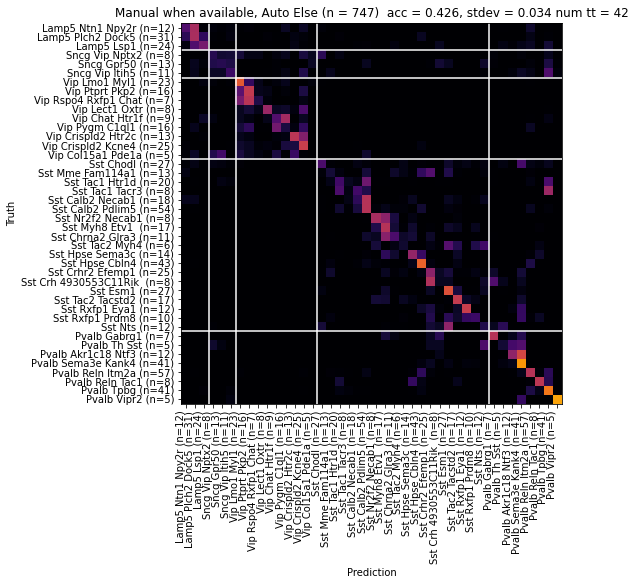

In [63]:
fig_2b,ax2b,gini_2b,confdf_2b,verbose_scores_2b = rfc_stratified(final_merged,
                                                             final_feat_cols,
                                                             labels_col,
                                                             "Manual when available, Auto Else (n = {}) ".format(len(final_merged)),
                                                             ttype_ids
                                                            )

In [65]:
fig_2b.savefig("./Auto_And_Manual_Combo_Pred.png",dpi=300,bbox_inches='tight')
confdf_2b.to_csv("./Auto_And_Manual_Combo_Pred.csv")
with open("./Auto_And_Manual_Combo_Pred_Verbose.json","w") as j:
    json.dump(verbose_scores_2b,j)

In [66]:
final_merged[final_merged.columns[1:11]].to_csv("./Auto_And_Manual_Combo_SpecimensUsed.csv")

# Supplementary Figures 
##### Looking at overlap between autotrace and  manual

In [3]:
olga_sps_used_supp = pd.read_csv("./CSVsFromOlga/classifier_auto_vs_manual_used_488.csv")['specimen_id'].values

In [4]:

labels = pd.read_csv(LABELS_FILE)
n_0 = labels.shape[0]
print("Originally n={}".format(n_0))
labels = labels[labels['Analysis_Call']!='Drop']
n_drop = labels.shape[0]
print("Dropping {} indicated by QC Sheet, n={}".format(n_0-n_drop, n_drop))

labels_col = "Lockdown VISp Tree Mapping"
mapping_qual_col = "Lockdown VISp Tree Call"

# remove non vis cells
labels = labels[labels['VIS']==True]
n_1 = labels.shape[0]
non_vis_cells = n_drop-n_1
print(f"Dropping {non_vis_cells} Remaining Non Visual Cortex Cells, n={labels.shape[0]}")
n_vis_drop = n_1

# Drop POOR Quality Transcriptomics
labels = labels[labels['Lockdown VISp Tree Call']!='PoorQ']
n_poor_q_drop = labels.shape[0]

labels = labels[labels['Auto_Manual_Call']=='Has GS']
n_after_auto_only_drop =labels.shape[0] 

# Drop n<5 ttypes
ttype_count_dict = labels[labels_col].value_counts().to_dict()
above_cutoff = [k for k,v in ttype_count_dict.items() if int(v) >4 ]
labels = labels[labels[labels_col].isin(above_cutoff)]
unique_ttypes = sorted(labels[labels_col].unique())
n_poor_q_drop_n_per_ttype_drop = labels.shape[0]


print("n={} After dropping poor quality".format(n_poor_q_drop))
print("n={} After dropping auto only".format(n_after_auto_only_drop))
print("n={} After dropping cells in n<5 ttypes".format(n_poor_q_drop_n_per_ttype_drop))
print(f"{len(above_cutoff)} Unique Ttypes with n>=5")




Originally n=823
Dropping 7 indicated by QC Sheet, n=816
Dropping 3 Remaining Non Visual Cortex Cells, n=813
n=782 After dropping poor quality
n=528 After dropping auto only
n=488 After dropping cells in n<5 ttypes
38 Unique Ttypes with n>=5


In [5]:
set(labels.specimen_id.values) == set(olga_sps_used_supp)

True

In [ ]:
FULLY_AUTO_UNMASKED_FEATURE_FILE = os.path.abspath("../../Swc_Files_NewConnection_NewRelabelAlgoV2/FromOlga_auto383_unmasked_Features/RawFeatureWide.csv")
FULLY_AUTO_FEATURE_FILE = "../../Swc_Files_NewConnection_NewRelabelAlgoV2/FeaturesCleaned/RawFeatureWide.csv"
FULLY_MANUAL_FEATURE_FILE = os.path.abspath("../../ManualFeatures/RawFeatureWide.csv")
MIXED_AUTO_MANUAL_FEATURE_FILE = "../../AutoCleanManualMixedFeatures/RawFeatureWide.csv"
LABELS_FILE = "../../PAtchSeq_Inhib_Autotrace_Paper_Cells.csv"
OLGA_CELLS_USED_MIXED = "CSVsFromOlga/classifier_auto_and_manual_used_750.csv"

In [39]:

auto_df = pd.read_csv(FULLY_AUTO_FEATURE_FILE)
auto_merged = auto_df.merge(labels,left_on='specimen_id',right_on='specimen_id')


manual_df = pd.read_csv(FULLY_MANUAL_FEATURE_FILE)
manual_merge = manual_df.merge(labels,left_on='specimen_id',right_on='specimen_id')

assert set(auto_merged['Cell Specimen Id'].to_list()) == set(manual_merge['specimen_id'].to_list())

print(auto_merged.shape)
print(manual_merge.shape)


(488, 58)
(488, 58)


In [40]:
# if a cell is in the unmasked feature set, replace it with the unmasked feature value
auto_unmasked_df = pd.read_csv(FULLY_AUTO_UNMASKED_FEATURE_FILE)
auto_unmasked_df = auto_unmasked_df.merge(labels,left_on='specimen_id',right_on='specimen_id')
replace_ids = [s for s in auto_merged.specimen_id if s in auto_unmasked_df.specimen_id.values]
nreplace = len(replace_ids)
print("Replacing {} of the {} cells with unmasked features".format(nreplace,auto_merged.shape[0] ))

Replacing 340 of the 488 cells with unmasked features


In [41]:
auto_merged = auto_merged.set_index('specimen_id')
auto_unmasked_df = auto_unmasked_df.set_index('specimen_id')


In [45]:
for spid in replace_ids:
    auto_merged.loc[spid] = auto_unmasked_df.loc[spid]

In [49]:
auto_merged = auto_merged.reset_index()

### Supplementary Manual

-----------------------------------------------------------------
RFC by Lockdown VISp Tree Mapping
-----------------------------------------------------------------

There are 38 unique labels in the 488 cells

Sst Calb2 Pdlim5 (n=32)         32
Sst Hpse Cbln4 (n=29)           29
Pvalb Reln Itm2a (n=24)         24
Lamp5 Plch2 Dock5 (n=21)        21
Sst Esm1 (n=20)                 20
Sst Crhr2 Efemp1 (n=19)         19
Pvalb Tpbg (n=19)               19
Sst Chodl (n=16)                16
Sst Tac1 Htr1d (n=16)           16
Vip Lmo1 Myl1 (n=15)            15
Vip Crispld2 Kcne4 (n=15)       15
Sst Myh8 Etv1  (n=14)           14
Pvalb Sema3e Kank4 (n=14)       14
Sst Hpse Sema3c (n=13)          13
Sst Tac2 Tacstd2 (n=13)         13
Sncg Gpr50 (n=13)               13
Lamp5 Lsp1 (n=13)               13
Vip Ptprt Pkp2 (n=12)           12
Sst Rxfp1 Eya1 (n=11)           11
Vip Crispld2 Htr2c (n=11)       11
Sst Calb2 Necab1 (n=11)         11
Sst Mme Fam114a1 (n=11)         11
Vip Pygm C1ql1 (n=

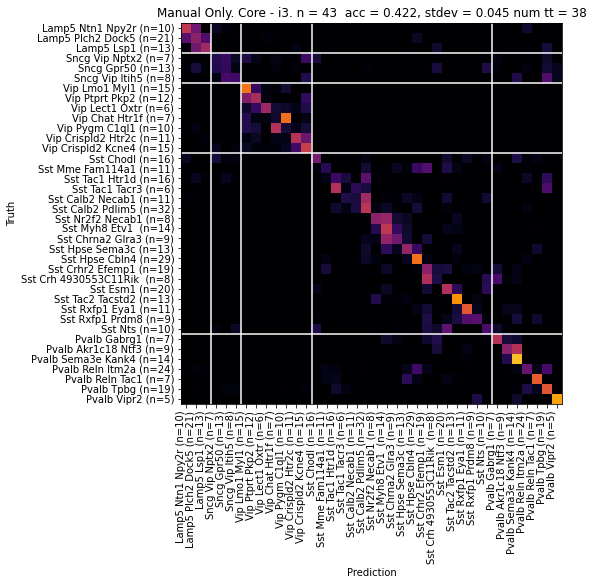

In [112]:
fig_sup_man,ax_sup_man,gini_sup_man,conf_df_sup_man,verbose_scores_sup_man = rfc_stratified(manual_merge,
                            final_feat_cols,
                            labels_col,
                            "Manual Only. Core - i3. n = {} ".format(len(final_feat_cols)),
                            ttype_ids
                           )

In [114]:
fig_sup_man.savefig("./Supp_Manual_Pred.png",dpi=300,bbox_inches='tight')
conf_df_sup_man.to_csv("./Supp_Manual_Pred.csv")
with open("./Supp_Manual_Pred_Verbose.json","w") as j:
    json.dump(verbose_scores_sup_man,j)

### Supplementary Auto

-----------------------------------------------------------------
RFC by Lockdown VISp Tree Mapping
-----------------------------------------------------------------

There are 38 unique labels in the 488 cells

Sst Calb2 Pdlim5 (n=32)         32
Sst Hpse Cbln4 (n=29)           29
Pvalb Reln Itm2a (n=24)         24
Lamp5 Plch2 Dock5 (n=21)        21
Sst Esm1 (n=20)                 20
Sst Crhr2 Efemp1 (n=19)         19
Pvalb Tpbg (n=19)               19
Sst Tac1 Htr1d (n=16)           16
Sst Chodl (n=16)                16
Vip Lmo1 Myl1 (n=15)            15
Vip Crispld2 Kcne4 (n=15)       15
Pvalb Sema3e Kank4 (n=14)       14
Sst Myh8 Etv1  (n=14)           14
Lamp5 Lsp1 (n=13)               13
Sst Hpse Sema3c (n=13)          13
Sncg Gpr50 (n=13)               13
Sst Tac2 Tacstd2 (n=13)         13
Vip Ptprt Pkp2 (n=12)           12
Sst Mme Fam114a1 (n=11)         11
Vip Crispld2 Htr2c (n=11)       11
Sst Calb2 Necab1 (n=11)         11
Sst Rxfp1 Eya1 (n=11)           11
Sst Nts (n=10)    

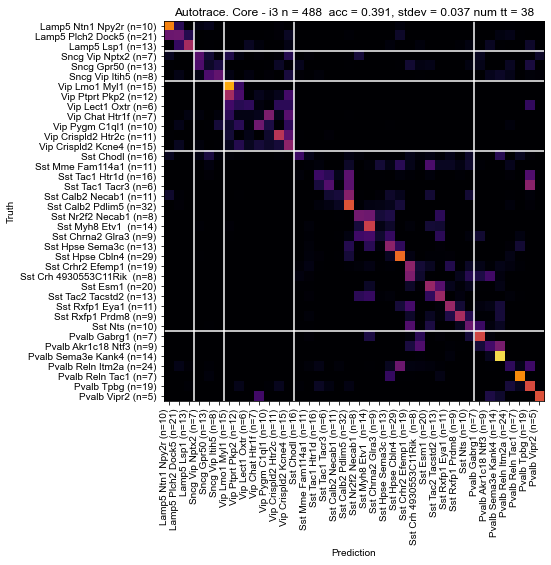

In [56]:
fig_sup_auto,ax_sup_auto,gini_sup_auto,conf_df_sup_auto,verbose_scores_sup_auto = rfc_stratified(auto_merged,
                                                                        final_feat_cols,
                                                                        labels_col,
                                                                        "Autotrace. Core - i3 n = {} ".format(len(auto_merged)),
                                                                        ttype_ids)

In [57]:
fig_sup_auto.savefig("./Supp_Auto_Pred_388Unmasked.png",dpi=300,bbox_inches='tight')
conf_df_sup_auto.to_csv("./Supp_Auto_Pred_388Unmasked.csv")
with open("./Supp_Auto_Pred_Verbose_388Unmasked.json","w") as j:
    json.dump(verbose_scores_sup_auto,j)